This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch internet, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU&feature=youtu.be&t=15m38s) at 15:36 or in [here](https://habrahabr.ru/post/275429/) **but in 2D**. You can google, search code at github, whatever, but the network should be based on TensoFlow.

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver` plot). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/hov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
init = tf.initializers.random_uniform(-1,1)

In [3]:
def discriminator(inpt, reuse):
    with tf.variable_scope("Discriminator", reuse=reuse):
        dl1 = tf.layers.dense(inpt,  20, activation=tf.nn.relu, name="dl1", kernel_initializer=init)
#         dl2 = tf.layers.dense( dl1, 100, activation=tf.nn.relu, name="dl2", kernel_initializer=init)
        dl3 = tf.layers.dense( dl1,  20, activation=tf.nn.relu, name="dl3", kernel_initializer=init)
        dis = tf.layers.dense( dl3,   1, name="dis")
        prob= tf.sigmoid(dis)
    return dis, prob

In [4]:
inX = tf.placeholder(tf.float32, shape=[None, 1], name="X")
y   = tf.placeholder(tf.float32, shape=[None, 1], name="target")

dis, dis_prob = discriminator(inX, False)

In [5]:
z  = tf.placeholder(tf.float32, shape=[None, 1], name="z")

with tf.variable_scope("Generator"):

    gl1 = tf.layers.dense(z,   20, activation=tf.nn.relu, name="gl1", kernel_initializer=init)
    gl2 = tf.layers.dense(gl1, 20, activation=tf.nn.relu, name="gl2", kernel_initializer=init)
#     gl3 = tf.layers.dense(gl2, 20, activation=tf.nn.relu, name="gl3", kernel_initializer=init)
#     gl4 = tf.layers.dense(gl3, 20, activation=tf.nn.relu, name="gl4", kernel_initializer=init)
    gen = tf.layers.dense(gl2,  1, name="gen")
    
combined, prob_combined = discriminator(gen, True)

In [6]:
gen_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Discriminator")

In [7]:
dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis,      labels=y))
gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=combined, labels=y))

In [8]:
writer = tf.summary.FileWriter('log/')

In [9]:
writer.add_graph(tf.get_default_graph())

In [10]:
writer.close()

In [11]:
train_gen = tf.train.RMSPropOptimizer(0.01).minimize(gloss, var_list=gen_vars)
train_dis = tf.train.RMSPropOptimizer(0.01).minimize(dloss, var_list=disc_vars)

In [12]:
data = np.random.normal(-5, 1, size=(1000,1))

In [13]:
def sampleNoise(batch_size):
    return (np.linspace(-7, -3, batch_size) + np.random.uniform(-0.01, 0.01, batch_size))[None].T

In [14]:
def generate_data_for_dist(batch_size):
    
    real_data = np.random.choice(data[:,0], (batch_size, 1))
    generated_data = sess.run(gen, feed_dict={z: sampleNoise(batch_size)})
    
    y = np.ones((2*batch_size, 1))
    y[:batch_size] = 0
    return np.concatenate((real_data, generated_data)),y

In [15]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
l = np.linspace(-12, 2, 100)[None].T
noise = np.linspace(-10, 5, 100000)[None].T

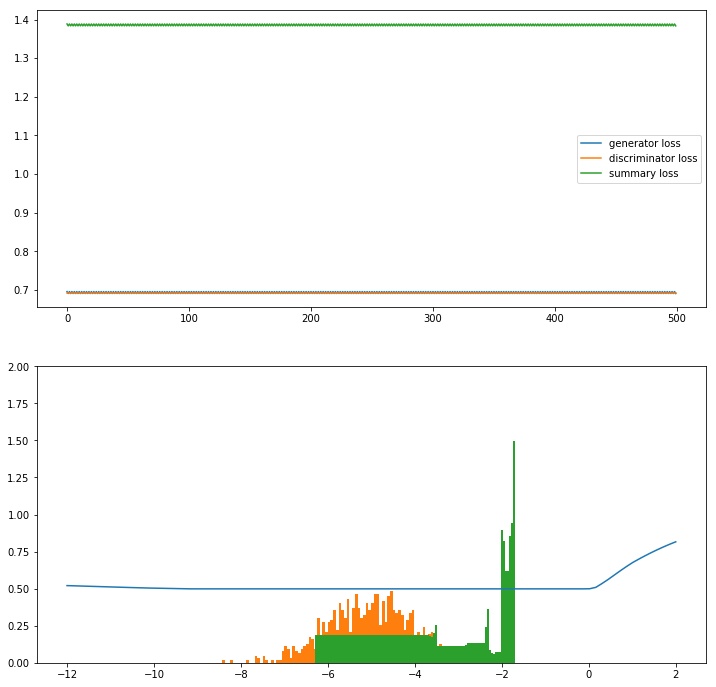

gen  0.6906501
dis  0.6931503
epoch 5000


In [17]:
num_epochs = 5000
batch_size = 2

glosshist=[]
dlosshist=[]

with tf.device("/device:GPU:0"):
    for epoch in range(num_epochs):

        X, Y = generate_data_for_dist(batch_size)

        _, dis_train_err = sess.run([train_dis, dloss], feed_dict={inX: X, y: Y})
        _, gen_train_err = sess.run([train_gen, gloss],
                                 feed_dict={z: sampleNoise(batch_size),
                                            y: np.zeros((batch_size,1))})

        dlosshist.append(dis_train_err)
        glosshist.append(gen_train_err)

        out = sess.run(dis_prob, feed_dict={inX: l})
        generated = sess.run(gen, feed_dict={z: noise})
        
        clear_output(wait=True)
        plt.figure(figsize=(12,12))
        plt.subplot(211)
        glh = np.array(glosshist[-500:])
        dlh = np.array(dlosshist[-500:])
        plt.plot(glh, label="generator loss")
        plt.plot(dlh, label="discriminator loss")
        plt.plot(glh + dlh, label="summary loss")
        plt.legend()

        plt.subplot(212)
        plt.plot(l, out);

        plt.hist(data, 100, density=True)
        plt.hist(generated, 100, density=True)
        plt.ylim(0,2)

        plt.show()

        print("gen ", gen_train_err)
        print("dis ", dis_train_err)
        print("epoch", len(glosshist))

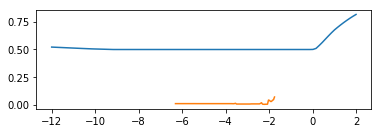

In [18]:

out = sess.run(dis_prob, feed_dict={inX: l})
plt.subplot(212)
plt.plot(l, out);

# generated = sess.run(gen, feed_dict={z: noise})
hist = np.histogram(generated, 100)
plt.plot(hist[1][:-1], hist[0].astype(float)/len(generated));

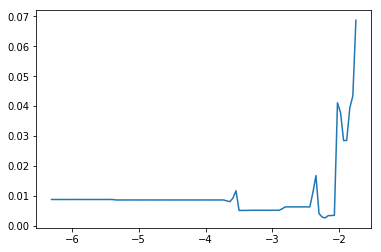

In [19]:
hist = np.histogram(generated, 100)
plt.plot(hist[1][:-1], hist[0].astype(float)/len(generated));

In [20]:
generated

array([[-6.3044558],
       [-6.3044033],
       [-6.3043513],
       ...,
       [-2.024552 ],
       [-2.0245633],
       [-2.0245752]], dtype=float32)

In [21]:
out = sess.run(dis_prob, feed_dict={inX: l})

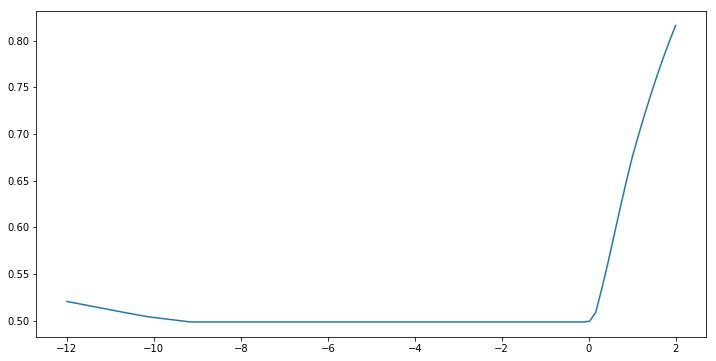

In [22]:
plt.figure(figsize=(12,6))
plt.plot(l, out);

In [23]:
generated = sess.run(gen, feed_dict={z: np.linspace(-10,10,10000)[None].T})

In [24]:
generated.min(), generated.mean(), generated.max()

(-6.3044558, -3.2790813, -1.7043269)

In [25]:
data.min(), data.mean(), data.max()

(-8.435152592069873, -5.021743357929947, -2.20127537429546)

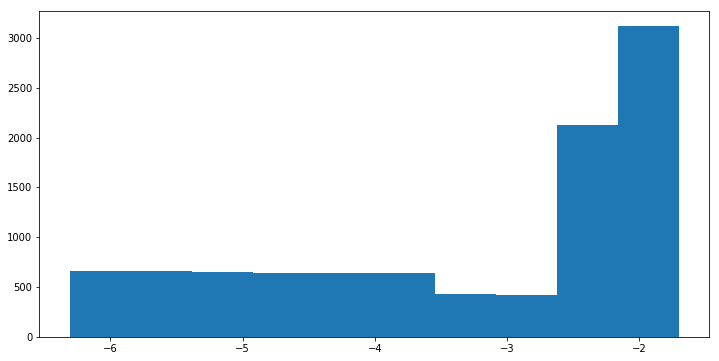

In [26]:
plt.figure(figsize=(12,6))
plt.hist(generated, 10);

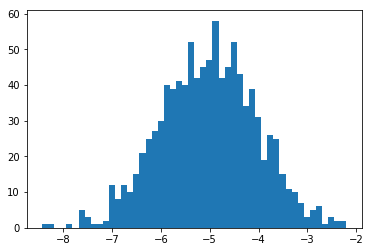

In [27]:
plt.hist(data, bins=50);